## Analyze A/B Test Results

This project was a part of the Udacity Data Analyst Nanodegree Program. It was meant to assure us have mastered the subjects covered in the statistics lessons.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [References](#references)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project is about analyzing the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
random.seed(42)

`1.` Read in the ab_data.csv data. Store it in df.

a. Read in the dataset and take a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Rows with missing values

In [7]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We should only use the rows that we can feel confident in the accuracy of the data. Therefore, we will remove the rows that are not aligned.

a. Create a new dataset that meets the specifications and store a new dataframe **df2**.

In [8]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
df2.reset_index(drop=True, inplace=True)

b. Double check all of the correct rows were removed - this should be 0

In [10]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Explore **df2**.

a. The number of unique **user_id**s in **df2**.

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.

In [12]:
df2[df2['user_id'].duplicated()==True]['user_id']

2862    773192
Name: user_id, dtype: int64

c. The row information for the repeat **user_id**.

In [13]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, as we shouldn't be counting the same user more than once.

In [14]:
df2.drop_duplicates(subset=['user_id'],inplace=True)

In [15]:
df2.reset_index(drop=True, inplace=True)

`4.` Analyze **df2**.

a. The probability of an individual converting regardless of the page they receive.

In [16]:
p = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p

0.11959708724499628

b. Given that the individual was in the `control` group, what is the probability they converted?

In [17]:
p_cont = df2.query('group == "control"').query('converted == 1')['user_id'].nunique() / df2.query('group == "control"')['user_id'].nunique()
p_cont

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treat = df2.query('group == "treatment"').query('converted == 1')['user_id'].nunique() / df2.query('group == "treatment"')['user_id'].nunique()
p_treat

0.11880806551510564

d .Calculate the observed difference in converted success rate.

In [19]:
obs_diff = p_treat - p_cont
obs_diff

-0.0015782389853555567

e. The probability that an individual received the new page.

In [20]:
df2.query('landing_page == "new_page"')['user_id'].nunique()/ df2['user_id'].nunique()

0.5000619442226688

> If this value differs far from 0.5, we need to do the sanity check for the population sizing invariants with a specific confidence level (e.g. 95%)

#### Sanity Check: Population sizing invariants
Check whether the treatment population and the control population are actually comparable. According to the Central Limit Theorem, we can assume the distribution of the data is normal because the sample size is large enough (290584). If the experiment is set up correctly, the true probability should be 0.5

In [21]:
# Return the value of critical z
def get_z_crit(alpha):
    return -norm.ppf(alpha / 2) # two-tailed test

# Compute the confidence interval around the true probability of 0.5
# Calculate the observed proprotion of unique user in the treatment group
def sanity_check(N_cont, N_exp, alpha, p=0.5):
    SE = np.sqrt(p * (1 - p) / (N_cont + N_exp))
    MOE = SE * get_z_crit(alpha)
    lb, ub = p - MOE, p + MOE
    # Observed proportion
    phat = N_exp / (N_cont + N_exp)
    if (phat >= lb) & (phat <= ub):
        return print('Confidence Interval:\n{}, {}'.format(lb, ub)), print('Observed proportion: {}'.format(phat)), print('Sanity check passed')
    else:
        return print('Confidence Interval:\n{}, {}'.format(lb, ub)), print('Observed proportion: {}'.format(phat)), print('Sanity check failed')

In [22]:
Ncont = df2.query('group == "control"')['user_id'].nunique()
Nexp = df2.query('group == "treatment"')['user_id'].nunique()
sanity_check(Ncont, Nexp, 0.05);

Confidence Interval:
0.4981820486936518, 0.5018179513063482
Observed proportion: 0.5000619442226688
Sanity check passed


> Sanity Check passed: We can be confident that 95% of the time, the observed proportion of user falls within the confidence interval.

f. Considering the results above, is there sufficient evidence to say that the new treatment page leads to more conversions?

> There is not sufficient evidence to say that the new treatment page leads to more conversion than old page. In this dataset, the converted rate in the control (old page) group is higher than the converted rate in the treatment (new page) group by about 0.16%. This small difference could appear by chance. In order to figure out whether this difference is significant and not just due to chance, we need to do a hypothesis test.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  These questions are the difficult parts associated with A/B tests in general.  

`1.` For now, we need to make the decision just based on all the data provided. If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?

**$$H_0: p_{new}-p_{old} \le 0$$**

**$$H_1: p_{new}-p_{old} \gt 0$$**

**$p_{old}$** and **$p_{new}$** are the converted success rates for the old and new pages.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.
- Use a sample size for each page equal to the ones in **ab_data.csv**.
- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  

In [23]:
p = df2['converted'].mean() # The converted rate in ab_data.csv regardless of the page.
p

0.11959708724499628

a. The **converted rate** for $p_{new}$ under the null.

In [24]:
p_new = p

b. The **converted rate** for $p_{old}$ under the null.

In [25]:
p_old = p

c. Size of new_page group $n_{new}$.

In [26]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. Size of old_page group $n_{old}$.

In [27]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([0, 1], size = n_new, replace = True, p = [1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([0, 1], size = n_old, replace = True, p = [1-p_old, p_old])

g. Difference in converted rate between the two groups.

In [30]:
new_page_converted.mean() - old_page_converted.mean()

-0.001853292545473506

> This value is very near to zero. Here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values and store them in a numpy array called **p_diffs**.

In [31]:
p_diffs = []

# Simulate sampling distribution of the difference in converted rate under the null hypothesis
new_page_converted_simulation = np.random.binomial(n_new, p_new, size=10000)/n_new
old_page_converted_simulation = np.random.binomial(n_old, p_old, size=10000)/n_old
p_diffs = new_page_converted_simulation - old_page_converted_simulation
    
# Convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot sampling distribution of the difference in converted rate **p_diffs** under the null hypothesis

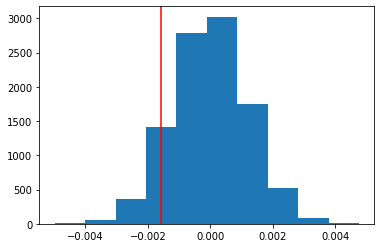

In [32]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'red');

In [33]:
p_diffs.mean()

3.6403905215631763e-06

> This is what we expected as the mean of the sampling distribution of the difference in conversion rate is very close to 0, if the null hypothesis is true.

j. Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.

In [34]:
# Compute p-value
(p_diffs>obs_diff).mean()

0.9082

k. What does p-value mean in terms of whether or not there is a difference between the new and old pages?

> We compare the observed difference to the values from the null hypothesis and compute the proportion of the values in the null distribution that are considered extreme based on the alternative hypothesis. This value is called p-value. In other words, it is the probability of the observed difference in converted rate occuring or a difference even more in favor of the converted rate of the new page is better than the old page, given that the converted rate of new page is actually lower than or equal to the converted rate of old page.

> As the p value is bigger than 0.05, with a Type I error rate of 5%, we do not have enough evidence that the new page is better than the new page. The observed difference in the converted rate between the two groups is not statistically significant. We fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Use [`stats.proportions_ztest`](http://knowledgetack.com/python/statsmodels/proportions_ztest/) to compute your test statistic and p-value.

In [36]:
convert = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
stat, pval = sm.stats.proportions_ztest(convert, nobs, alternative = 'larger')
print('p_value = {0:0.3f}'.format(pval))
print('z score = {0:0.3f}'.format(stat))

p_value = 0.905
z score = -1.311


n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The z-score gives us an idea of how far from the mean of the normal distribution a data point is. In the other words, it’s a measure of how many standard deviations below or above the mean. In this case, the observed difference in converted rate is 1.311 standard deviation below the mean of the sampling distribution under the null, which is 0. With a sampling distribution, a z-score of less than the z-critical value of ~1.6 means that we are likely to sample such a sample from the sampling distribution given an alpha of 0.05.

> We are getting similar p-values where both p-values are above the significance level of 0.05. Again, we failed to reject the null hypothesis with a Type I error rate of 5%. We have evidence that the observed difference in converted rate was likely to come from the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` The result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we should perform logistic regression in this case.

b. The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
df2['ab_page'] = df2['group'].apply(lambda x: 1 if x == 'treatment' else 0)

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import the regression model. Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [39]:
# Fit linear model and obtain the results
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model.

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:24:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [41]:
1/np.exp(-0.015)

1.015113064615719

> Predicted conversion in old page is 1.015 times more likely than in new page but this difference is not statistically significant.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

> The hypotheses in the regression model are:

**$$H_0: p_{new}-p_{old} = 0$$**

**$$H_1: p_{new}-p_{old} \neq 0$$**

> This is a two-sided test. Null hypothesis implies that there is no relationship between the probability of conversion and ab_page, where the estimate is equal to zero. In other words, there is no difference in conversion rate between the two groups. The alternative is that the difference in conversion rate is not zero.

> In Part II, that was a one-sided test. Null hypothesis implies that conversion rate of the new page is less than or equal to the conversion rate of the old page, whereas the alternative is that conversion rate of the new page is better than the conversion rate of the old page.

f. Now, considering other things that might influence whether or not an individual converts.  Why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> In order to predict whether or not an individual converts, we need to have the individual factors as the predictors in the regression model. These predictors could be gender, age, occupation, country etc.

> Though adding additional terms like higher order terms might allow us to better predict the response, adding these terms makes interpreting the results of the data more complex. We should only do it when we specifically see the relationship between the predictors, having an interaction effect on the response.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

Does it appear that country had an impact on conversion?

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
# Create the dummy variables
dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(dummies)

In [44]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [45]:
# Fit linear model and obtain the results
lm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
result2 = lm2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        11:24:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [46]:
np.exp(result2.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [47]:
1/0.960062

1.0415993967056294

In [48]:
1/0.985168

1.0150553002127556

> **Results Intepretation**
- Predicted conversion in old page is 1.015 times more likely than in new page.
- The individual living in UK is predicted to be 1.01 times more likely to convert compared to the individual living in US, regardless of the type of pages. 
- The individual living in US is predicted to be 1.04 times more likely to convert compared to the individual living in CA, regardless of the type of pages.

> All these differences is not statistically significant.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [49]:
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']

In [50]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [51]:
# Fit linear model and obtain the results
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
result3 = lm3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 22 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        11:24:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> **Results interpretation of the interaction between dummy coded categorical variables**
- With the interaction the following six groups were generated: CA_new_page, UK_new_page, US_new_page, CA_old_page, UK_old_page, US_old_page
    - Coefficient for US_old_page: intercept
    - Coefficient for US_new_page: intercept + ab_page
    - Coefficient for CA_old_page: intercept + CA
    - Coefficient for CA_new_page: intercept + CA + ab_page + CA_ab_page
    - Coefficient for UK_old_page: intercept + UK
    - Coefficient for UK_new_page: intercept + UK + ab_page + UK_ab_page

In [52]:
coef = np.exp(result3.params)

CA_new = coef[0] + coef[1] + coef[2] + coef[4]
UK_new = coef[0] + coef[1] + coef[3] + coef[5]
US_new = coef[0] + coef[1]

CA_old = coef[0] + coef[2]
UK_old = coef[0] + coef[3]
US_old = coef[0]

print('New Page')
print('CA: {}'.format(CA_new))
print('UK: {}'.format(UK_new))
print('US: {}'.format(US_new))
print('')
print('Old Page')
print('CA: {}'.format(CA_old))
print('UK: {}'.format(UK_old))
print('US: {}'.format(US_old))

New Page
CA: 3.053646594031197
UK: 3.142992533885524
US: 1.116824153624537

Old Page
CA: 1.1198026370026495
UK: 1.1314502092167007
US: 0.13717773852380238


> Based on the results, adding interaction terms is not useful in predicting the probability of conversion. For the interaction terms, the associated p-values are not statistcally significant. There is no interection between the type of page and the country, e.g. a user living in Canada isn't statistically significant more likely to convert when they see the old page than when they see the new page. Hence, we failed to reject the null hypothesis. This indicates that it is likely to observe such insubstantial association between the predictors and the response due to chance, meaning that whether or not an individuals converts does not depend on the pages they see and which country are they from. However, this is still a valuable insight that hardens the findings of prior tests.

**Quick glimpse at the conversion rates by date, weekday and hour to see whether there is a specific period of time that the users convert more than the other.**

In [53]:
import datetime

In [54]:
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [55]:
df_new.groupby([df_new['timestamp'].dt.date, 'landing_page'])['converted'].mean()

timestamp   landing_page
2017-01-02  new_page        0.119874
            old_page        0.125568
2017-01-03  new_page        0.113781
            old_page        0.113809
2017-01-04  new_page        0.116649
            old_page        0.121922
2017-01-05  new_page        0.114988
            old_page        0.123230
2017-01-06  new_page        0.123462
            old_page        0.115350
2017-01-07  new_page        0.116205
            old_page        0.120987
2017-01-08  new_page        0.120746
            old_page        0.118887
2017-01-09  new_page        0.118065
            old_page        0.119644
2017-01-10  new_page        0.126344
            old_page        0.112864
2017-01-11  new_page        0.115091
            old_page        0.118870
2017-01-12  new_page        0.122344
            old_page        0.122048
2017-01-13  new_page        0.111248
            old_page        0.116911
2017-01-14  new_page        0.119260
            old_page        0.126756
2017-01-15  n

In [56]:
df_new.groupby([df_new['timestamp'].dt.weekday, 'landing_page'])['converted'].mean()

timestamp  landing_page
0          new_page        0.119491
           old_page        0.122795
1          new_page        0.122339
           old_page        0.116748
2          new_page        0.118837
           old_page        0.121835
3          new_page        0.118209
           old_page        0.121729
4          new_page        0.117538
           old_page        0.115834
5          new_page        0.117058
           old_page        0.124567
6          new_page        0.117431
           old_page        0.119518
Name: converted, dtype: float64

In [57]:
df_new.groupby([df_new['timestamp'].dt.hour, 'landing_page'])['converted'].sum()

timestamp  landing_page
0          new_page        722
           old_page        711
1          new_page        673
           old_page        720
2          new_page        681
           old_page        687
3          new_page        716
           old_page        678
4          new_page        640
           old_page        731
5          new_page        725
           old_page        755
6          new_page        691
           old_page        772
7          new_page        701
           old_page        729
8          new_page        719
           old_page        718
9          new_page        744
           old_page        754
10         new_page        710
           old_page        714
11         new_page        721
           old_page        772
12         new_page        757
           old_page        746
13         new_page        749
           old_page        700
14         new_page        715
           old_page        728
15         new_page        725
           old_

> We can see that the conversion rates are pretty similar across the date, weekday and hour of the day. There isn't a day or a particular period of the day is standout. We could also fit them into the logistic regression model to see if there is a significant effect on conversion.

In [58]:
df_new['day'] = df_new['timestamp'].dt.weekday
period = df_new['day'].apply(lambda x: 'weekdays' if x<5 else 'weekends')
dummies = pd.get_dummies(period)
df_new = df_new.join(dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page,day,weekdays,weekends
user_id,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,5,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,6,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0,1,0


In [59]:
### Fit linear model and obtain the results
lm4 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'weekends']])
result4 = lm4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 22 Oct 2020   Pseudo R-squ.:               8.088e-06
Time:                        11:24:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9889      0.009   -226.066      0.000      -2.006      -1.972
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
weekends       0.0006      0.013      0.049      0.961      -0.024       0.026
==============================================================================
"""

> On weekends, conversion isn't significantly different than on weekdays, regardless of the type of page.

In [60]:
df_new['hour'] = df_new.timestamp.dt.hour
df_new['minute'] = df_new.timestamp.dt.minute 

# split timestamp into hour and minutes
df_new['time_in_min'] = df_new['hour']*60 + df_new['minute']

# There are 24 hrs in a day, so we can split these hours into 4 sections
bin_edges = [0, 6*60, 12*60, 18*60, 24*60]
bin_labels = ['overnight', 'morning', 'afternoon', 'evening']
df_new['time_of_day'] = pd.cut(df_new['time_in_min'], bin_edges, labels=bin_labels)

In [61]:
dummies = pd.get_dummies(df_new['time_of_day'])
df_new = df_new.join(dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,...,weekdays,weekends,hour,minute,time_in_min,time_of_day,overnight,morning,afternoon,evening
user_id,,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,...,0,1,23,8,1388,evening,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,...,1,0,14,44,884,afternoon,0,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,...,1,0,14,4,844,afternoon,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,...,0,1,3,14,194,overnight,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,...,1,0,13,14,794,afternoon,0,0,1,0


In [62]:
### Fit linear model and obtain the results
lm5 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'morning', 'afternoon', 'evening']])
result5 = lm5.fit()
result5.summary()

Optimization terminated successfully.
         Current function value: 0.366100
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 22 Oct 2020   Pseudo R-squ.:               5.992e-05
Time:                        11:24:17   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01257
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0217      0.013   -156.811      0.000      -2.047      -1.996
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
morning        0.0419      0.016      2.581      0.010       0.010       0.074
afternoon      0.0417      0.016      2.571      0.010       0.010       0.074
evening        0.0476      0.016      2.930      0.003       0.016       0.079
==============================================================================
"""

In [63]:
np.exp(result5.params)

intercept    0.132429
ab_page      0.985169
morning      1.042800
afternoon    1.042600
evening      1.048706
dtype: float64

> Based on the results, it shows that users are predicted to convert more in the morning, afternoon and evening than overnight and the p-values associated are all statistically significant. However, the predicted difference between the conversion among these three period of time is not statistically significant, as the confidence intervals overlap.

<a id='conclusions'></a>
## Conclusions

> In part II, it was an **aggregate** approach using hypothesis testing to understand whether or not the proportion of users that converts using new page is better than the average using old page. The results showed that there is no significantly difference in conversion rate between the two groups.

> In part III,it was an **individual** approach using logistic regression to understand whether or not an individual converts depends on the pages they see and which country are they from. The results showed that having country as additional factor and adding interaction terms into the logistic regression model are not useful in predicting the probability of conversion. 
- The type of page does not correlate to the user conversion, which agrees with the A/B test. 
- The country where the user lives is not a good predictor for user conversion. 
- The interaction between type of page and country has no significant effects on conversion.
- Adding time factors worsens the model fit, as the R-squared decreases.

> The R-squared value is the highest for the second linear model, where we only fit the model with page and country, without the interaction terms. Even though this model isn't great, it fits better than the others. In other words, adding the interaction terms and time factor provides no improvement in the model. However, these are still valuable insights that hardens the findings of prior tests.

<a id='references'></a>
## References

- Intepretation of the interaction between dummy coded variables: https://www.theanalysisfactor.com/interaction-dummy-variables-in-linear-regression/

In [64]:
# Generate .html file in the workspace directory 
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results.ipynb'])

0